# Проверка гипотез для увеличения выручки интернет-магазина

## Задача

Выполнить приоритизацию гипотез и проанализировать результаты A/B-теста. Заказчик: отдел маркетинга интернет-магазина.

## Описание данных

Файл **hypothesis.csv**:
- Hypothesis — краткое описание гипотезы;
- Reach — охват пользователей по 10-балльной шкале;
- Impact — влияние на пользователей по 10-балльной шкале;
- Confidence — уверенность в гипотезе по 10-балльной шкале;
- Efforts — затраты ресурсов на проверку гипотезы по 10-балльной шкале. Чем больше значение Efforts, тем дороже проверка гипотезы.

Файл **orders.csv**:
- transactionId — идентификатор заказа;
- visitorId — идентификатор пользователя, совершившего заказ;
- date — дата, когда был совершён заказ;
- revenue — выручка заказа;
- group — группа A/B-теста, в которую попал заказ.

Файл **visitors.csv**:
- date — дата;
- group — группа A/B-теста;
- visitors — количество пользователей в указанную дату в указанной группе A/B-теста

## Оглавление

### [Шаг 1. Приоритизация гипотез](#hypotheses_prioritization)
### [Шаг 2. Анализ A/B-теста](#abtest_analysis)
1. [Кумулятивная выручка по группам](#1)
2. [Кумулятивный средний чек по группам](#2)
3. [Относительное изменение кумулятивного среднего чека группы B к группе A](#3)
4. [Кумулятивная конверсия по группам](#4)
5. [Относительное изменение кумулятивной конверсии группы B к группе A](#5)
6. [Количество заказов по пользователям](#6)
7. [Граница для определения аномальных пользователей](#7)
8. [Стоимость заказов](#8)
9. [Граница для определения аномальных заказов](#9)
10. [Статистическая значимость различий в конверсии между группами по «сырым» данным](#10)
11. [Статистическая значимость различий в среднем чеке заказа между группами по «сырым» данным](#11)
12. [Статистическая значимость различий в конверсии между группами по «очищенным» данным](#12)
13. [Статистическая значимость различий в среднем чеке заказа между группами по «очищенным» данным](#13)
14. [Решение по результатам теста](#14)

## Ход работы

#### Импортируем необходимые для работы библиотеки.

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from scipy import stats as st
import datetime as dt
import warnings
warnings.simplefilter('ignore')
pd.set_option('display.max_colwidth', 500)

## <a id='hypotheses_prioritization'>Шаг 1. Приоритизация гипотез</a>

In [2]:
def review_file(filename, title):
    '''
    Функция сохраняет данные в возвращаемую переменную
    и выводит необходимую информацию на экран.
    
    Аргументы:
        filename (str): путь к файлу.
        
        title (str): название таблицы.
    '''
    
    table = pd.read_csv(filename)
    
    print('\033[1m'
          + f'Общая информация о таблице {title}:'
          + '\033[0m')
    print()
    table.info()
    print()
    
    if table.shape[0] > 10:
        print('\033[1m' 
              + f'Первые 10 строк таблицы {title}:'
              + '\033[0m')
        display(table.head(10))
    else:
        print('\033[1m'
              + f'Таблица {title}:'
              + '\033[0m')
        display(table)
        
    print('\033[1m'
          + f'Количество пропусков в каждом столбце таблицы {title}:'
          + '\033[0m')
    display(pd.DataFrame(table.isna().sum()))
    
    print('\033[1m'
          + f'Число дубликатов в таблице {title}: {table.duplicated().sum()}'
          + '\033[0m')
    
    return table

#### Откроем файл *hypothesis.csv* и изучим его.

In [3]:
hypotheses = review_file('/datasets/hypothesis.csv', 'с гипотезами')

Общая информация о таблице с гипотезами:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
Hypothesis    9 non-null object
Reach         9 non-null int64
Impact        9 non-null int64
Confidence    9 non-null int64
Efforts       9 non-null int64
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes

Таблица с гипотезами:


,Hypothesis,Reach,Impact,Confidence,Efforts
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5


Количество пропусков в каждом столбце таблицы с гипотезами:


,0
Hypothesis,0
Reach,0
Impact,0
Confidence,0
Efforts,0


Число дубликатов в таблице с гипотезами: 0


В файле **hypothesis.csv** находятся 9 гипотез по увеличению выручки интернет-магазина с указанными параметрами *Reach*, *Impact*, *Confidence* и *Effort*. Пропусков и дубликатов нет. Типы данных корректны.

***

#### Применим фреймворк *ICE* для приоритизации гипотез. Отсортируем их по убыванию приоритета.

$$ICE = \frac{Impact \cdot Confidence}{Efforts}$$

In [4]:
hypotheses['ICE'] = (
    (hypotheses['Impact'] * hypotheses['Confidence'] / hypotheses['Efforts'])
    .round(2)
)

hypotheses.sort_values(by='ICE', ascending=False)

,Hypothesis,Reach,Impact,Confidence,Efforts,ICE
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5,16.20
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6,13.33
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5,11.20
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3,8.00
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3,7.00
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10,2.00
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3,1.33
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8,1.12
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1,1.00


Наиболее перспективные гипотезы по *ICE*: 8, 0, 7, 6.

#### Применим фреймворк *RICE* для приоритизации гипотез. Отсортируем их по убыванию приоритета.

$$RICE = \frac{Reach \cdot Impact \cdot Confidence}{Efforts}$$

In [5]:
hypotheses['RICE'] = (
    (hypotheses['Reach'] * hypotheses['Impact'] * hypotheses['Confidence'] 
     / hypotheses['Efforts'])
    .round(2)
)

hypotheses.sort_values(by='RICE', ascending=False)

,Hypothesis,Reach,Impact,Confidence,Efforts,ICE,RICE
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5,11.20,112.0
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3,7.00,56.0
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6,13.33,40.0
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3,8.00,40.0
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5,16.20,16.2
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8,1.12,9.0
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10,2.00,4.0
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3,1.33,4.0
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1,1.00,3.0


Наиболее перспективные гипотезы по *RICE*: 7, 2, 0, 6. 

Гипотеза о скидочной акции в день рождения имеет очень низких охват пользователей, ведь, «к сожаленью, день рожденья только раз в году», в то время как гипотеза о сборе базы клиентов для email-рассылок имеет максимальный охват, хотя и без его учёта была одной из самых приоритетных. С учётом важности пользовательского охвата для интернет-магазина, прежде всего стоит проверить гипотезу об email-рассылках.

### Вывод

В файле **hypothesis.csv** находятся 9 гипотез по увеличению выручки интернет-магазина с указанными параметрами *Reach*, *Impact*, *Confidence* и *Effort*. Пропусков и дубликатов нет. Типы данных корректны.

Наиболее перспективные гипотезы по *ICE*: 8, 0, 7, 6.

Наиболее перспективные гипотезы по *RICE*: 7, 2, 0, 6. 

Гипотеза о скидочной акции в день рождения (8) имеет очень низких охват пользователей, ведь, «к сожаленью, день рожденья только раз в году», в то время как гипотеза о сборе базы клиентов для email-рассылок (7) имеет максимальный охват пользователей, хотя и без его учёта была одной из самых приоритетных. С учётом важности пользовательского охвата для интернет-магазина, прежде всего стоит проверить гипотезу об email-рассылках.

## <a id='abtest_analysis'>Шаг 2. Анализ A/B-теста</a>

#### Откроем файлы *orders.csv* и *visitors.csv* и изучим их.

In [6]:
orders = review_file('/datasets/orders.csv', 'с заказами')

Общая информация о таблице с заказами:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
transactionId    1197 non-null int64
visitorId        1197 non-null int64
date             1197 non-null object
revenue          1197 non-null int64
group            1197 non-null object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB

Первые 10 строк таблицы с заказами:


,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B
5,182168103,935554773,2019-08-15,2210,B
6,398296753,2900797465,2019-08-15,1860,B
7,2626614568,78758296,2019-08-15,1044,A
8,1576988021,295230930,2019-08-15,13710,A
9,1506739906,1882260405,2019-08-15,1855,B


Количество пропусков в каждом столбце таблицы с заказами:


,0
transactionId,0
visitorId,0
date,0
revenue,0
group,0


Число дубликатов в таблице с заказами: 0


In [7]:
orders['revenue'].describe().round()

count       1197.0
mean        8348.0
std        39191.0
min           50.0
25%         1220.0
50%         2978.0
75%         8290.0
max      1294500.0
Name: revenue, dtype: float64

In [8]:
orders['group'].value_counts()

B    640
A    557
Name: group, dtype: int64

Датафрейм **orders** состоит из 1 197 строк и 5 столбцов. Пропусков и дубликатов нет. Тип данных в столбце *date* — *object*, а не *datetime*.

***

In [9]:
visitors = review_file('/datasets/visitors.csv', 'с пользователями')

Общая информация о таблице с пользователями:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
date        62 non-null object
group       62 non-null object
visitors    62 non-null int64
dtypes: int64(1), object(2)
memory usage: 1.6+ KB

Первые 10 строк таблицы с пользователями:


,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756
5,2019-08-06,A,667
6,2019-08-07,A,644
7,2019-08-08,A,610
8,2019-08-09,A,617
9,2019-08-10,A,406


Количество пропусков в каждом столбце таблицы с пользователями:


,0
date,0
group,0
visitors,0


Число дубликатов в таблице с пользователями: 0


In [10]:
visitors['visitors'].describe()

count     62.000000
mean     607.290323
std      114.400560
min      361.000000
25%      534.000000
50%      624.500000
75%      710.500000
max      770.000000
Name: visitors, dtype: float64

In [11]:
visitors['group'].value_counts()

B    31
A    31
Name: group, dtype: int64

Датафрейм **visitors** состоит из 62 строк и 3 столбцов. Пропусков и дубликатов нет. Тип данных в столбце *date* — *object*, а не *datetime*.

***

#### Приведём типы данных в столбцах *date* датафреймов *orders* и *visitors* к типу *datetime64[ns]*.

In [12]:
orders['date'] = orders['date'].map(
    lambda x: dt.datetime.strptime(x, '%Y-%m-%d')
)

visitors['date'] = visitors['date'].map(
    lambda x: dt.datetime.strptime(x, '%Y-%m-%d')
)

***

#### Проверим данные на наличие ошибок.

In [13]:
group_a = orders.query('group == "A"')
group_b = orders.query('group == "B"')

wrong_indices = (
    pd.DataFrame(group_a['visitorId'].isin(group_b['visitorId']))
    .query('visitorId == True')
    .index
)

wrong_visitor_ids = group_a.loc[wrong_indices, 'visitorId'].unique()

wrong_visitor_ids.shape[0]

58

Оказалось, что 58 пользователей попали одновременно в контрольную и тестовую группы. Такого быть не должно.

In [14]:
wrong_data = orders[orders['visitorId'].isin(wrong_visitor_ids)]

print(
    'Доля пользователей, попавших в обе группы: {:.2%}'
    .format(wrong_data['visitorId'].nunique() / orders['visitorId'].nunique())
)

print(
    'Доля заказов, совершённых этими пользователями: {:.2%}'
    .format(wrong_data.shape[0] / orders.shape[0])
)

print(
    'Доля выручки от этих пользователей: {:.2%}'
    .format(wrong_data['revenue'].sum() / orders['revenue'].sum())
)

Доля пользователей, попавших в обе группы: 5.63%
Доля заказов, совершённых этими пользователями: 15.12%
Доля выручки от этих пользователей: 15.60%


Как мы видим, таких пользователей не так много, однако 15% заказов и выручки принесли именно они. Тем не менее, для корректного анализа теста от этих данных придётся избавиться.

In [15]:
orders = orders[np.logical_not(orders['visitorId'].isin(wrong_visitor_ids))]

***

### <a id='1'>1. Кумулятивная выручка по группам</a>

#### Создадим массив уникальных пар значений дат и групп теста.

In [16]:
dates_groups = orders[['date','group']].drop_duplicates()

#### Соберём агрегированные кумулятивные по дням данные о заказах.

In [17]:
orders_aggregated = (
    dates_groups
    .apply(
        lambda x: orders[
            np.logical_and(
                orders['date'] <= x['date'], 
                orders['group'] == x['group']
            )
        ]
        .agg({
            'date': 'max',
             'group': 'max',
             'transactionId': 'nunique',
             'visitorId': 'nunique',
             'revenue': 'sum'
        }), 
        axis=1
    )
    .sort_values(by=['date', 'group'])
)

#### Получим агрегированные кумулятивные по дням данные о посетителях интернет-магазина.

In [18]:
visitors_aggregated = (
    dates_groups
    .apply(
        lambda x: visitors[
            np.logical_and(
                visitors['date'] <= x['date'], 
                visitors['group'] == x['group']
            )
        ]
        .agg({
            'date': 'max',
            'group': 'max',
            'visitors' : 'sum'
        }), 
        axis=1
    )
    .sort_values(by=['date', 'group'])
)

#### Объединим обе таблицы в одной с понятными названиями столбцов.

In [19]:
cumulative_data = (
    orders_aggregated
    .merge(visitors_aggregated, left_on=['date', 'group'], right_on=['date', 'group'])
)

cumulative_data.columns = ['date', 'group', 'orders', 'buyers', 'revenue', 'visitors']

#### Построим графики кумулятивной выручки по дням и группам A/B-тестирования.

In [20]:
cumulative_revenue_a = cumulative_data[cumulative_data['group'] == 'A'][['date','revenue', 'orders']]
cumulative_revenue_b = cumulative_data[cumulative_data['group'] == 'B'][['date','revenue', 'orders']]

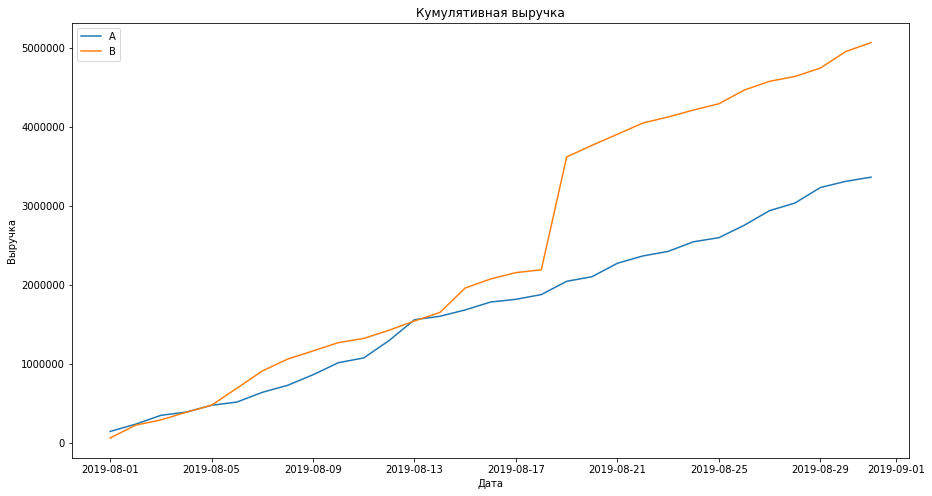

In [21]:
plt.figure(figsize=(15, 8))
plt.plot(cumulative_revenue_a['date'], cumulative_revenue_a['revenue'], label='A')
plt.plot(cumulative_revenue_b['date'], cumulative_revenue_b['revenue'], label='B')
plt.title('Кумулятивная выручка')
plt.xlabel('Дата')
plt.ylabel('Выручка')
plt.legend()
plt.show()

Группа B обгоняет группу A по кумулятивной выручке почти с самого начала. Стоит отметить резкий рост графика кумулятивной выручки группы B в промежутке 17-21 августа. Это может сигнализировать о всплесках числа заказов или о появлении очень дорогих заказов в выборке.

### <a id='2'>2. Кумулятивный средний чек по группам</a>

#### Построим графики среднего чека по группам — разделим кумулятивную выручку на кумулятивное число заказов.

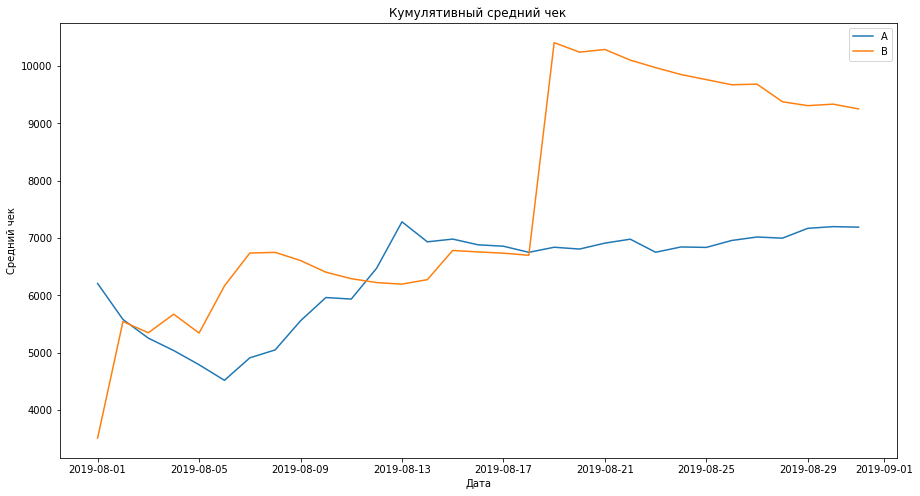

In [22]:
plt.figure(figsize=(15, 8))
plt.plot(
    cumulative_revenue_a['date'], 
    cumulative_revenue_a['revenue'] / cumulative_revenue_a['orders'], 
    label='A'
)

plt.plot(
    cumulative_revenue_b['date'], 
    cumulative_revenue_b['revenue'] / cumulative_revenue_b['orders'], 
    label='B'
)

plt.title('Кумулятивный средний чек')
plt.xlabel('Дата')
plt.ylabel('Средний чек')
plt.legend() 
plt.show()

Средний чек ведёт себя неравномерно на протяжении всего теста. Средний чек группы B резко растёт на том же самом временном промежутке, что и кумулятивная выручка этой группы. Заметно так называемое «возвращение к среднему», характерное для единоразовых мощных выбросов. Однозначно оценить эту метрику в разрезе групп по графику не удаётся.

### <a id='3'>3. Относительное изменение кумулятивного среднего чека группы B к группе A</a>

#### Построим график относительного различия для среднего чека.

In [23]:
merged_cumulative_revenue = (
    cumulative_revenue_a
    .merge(
        cumulative_revenue_b, 
        left_on='date', 
        right_on='date', 
        how='left', 
        suffixes=['A', 'B']
    )
)

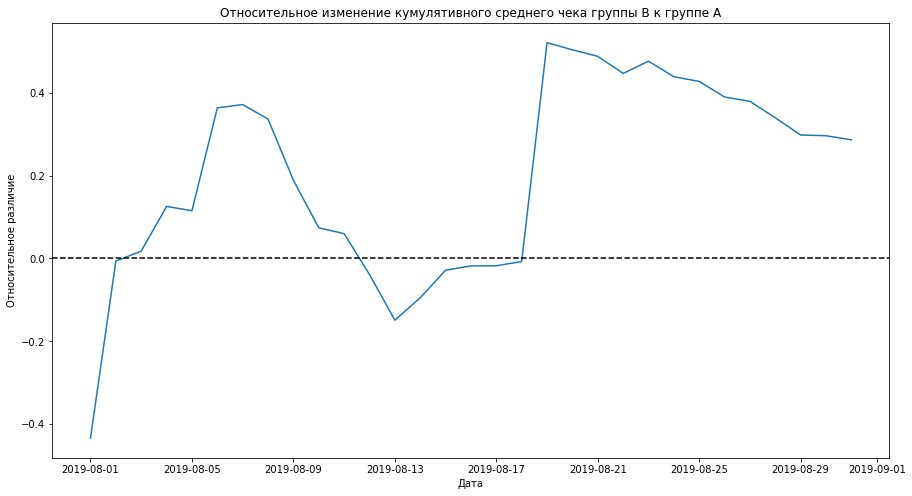

In [24]:
plt.figure(figsize=(15, 8))
plt.plot(
    merged_cumulative_revenue['date'], 
    (merged_cumulative_revenue['revenueB'] / merged_cumulative_revenue['ordersB']) / 
    (merged_cumulative_revenue['revenueA'] / merged_cumulative_revenue['ordersA']) - 1
)

plt.axhline(y=0, color='black', linestyle='--')
plt.title('Относительное изменение кумулятивного среднего чека группы B к группе A')
plt.xlabel('Дата')
plt.ylabel('Относительное различие')
plt.show()

В нескольких точках график различия между сегментами резко «скачет». Крупные заказы и выбросы, безусловно, присутствуют.

### <a id='4'>4. Кумулятивная конверсия по группам</a>

#### Проанализируем график кумулятивной конверсии.

In [25]:
cumulative_data['conversion'] = cumulative_data['orders'] / cumulative_data['visitors']
cumulative_data_a = cumulative_data[cumulative_data['group'] == 'A']
cumulative_data_b = cumulative_data[cumulative_data['group'] == 'B']

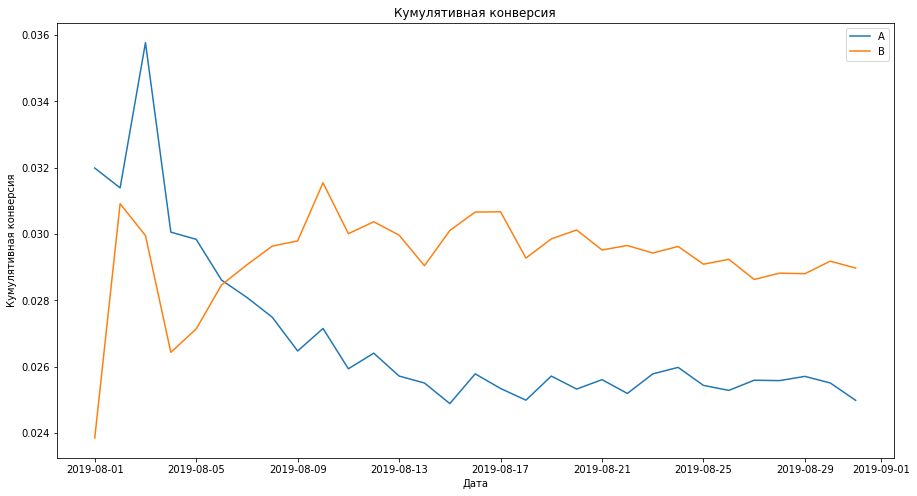

In [26]:
plt.figure(figsize=(15, 8))
plt.plot(cumulative_data_a['date'], cumulative_data_a['conversion'], label='A')
plt.plot(cumulative_data_b['date'], cumulative_data_b['conversion'], label='B')
plt.title('Кумулятивная конверсия')
plt.xlabel('Дата')
plt.ylabel('Кумулятивная конверсия')
plt.legend()
plt.show()

Кумулятивная конверсия группы A была лучше лишь в самом начале теста, после чего группа B вырвалась вперёд. К концу теста графики относительно стабилизировались.

### <a id='5'>5. Относительное изменение кумулятивной конверсии группы B к группе A</a>

#### Построим график относительного различия кумулятивных конверсий.

In [27]:
merged_cumulative_conversions = (
    cumulative_data_a[['date', 'conversion']]
    .merge(
        cumulative_data_b[['date', 'conversion']], 
        left_on='date', 
        right_on='date', 
        how='left', 
        suffixes=['A', 'B']
    )
)

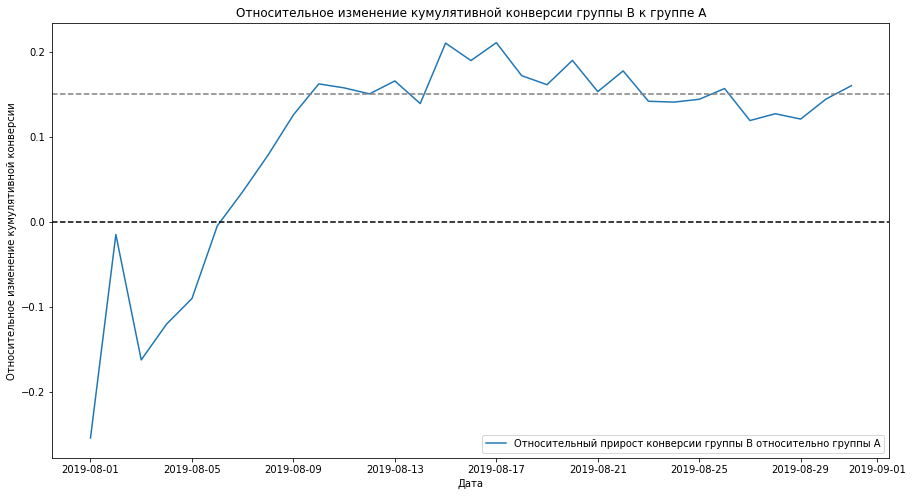

In [28]:
plt.figure(figsize=(15, 8))
plt.plot(
    merged_cumulative_conversions['date'], 
    merged_cumulative_conversions['conversionB'] / merged_cumulative_conversions['conversionA'] - 1, 
    label='Относительный прирост конверсии группы B относительно группы A'
)

plt.title('Относительное изменение кумулятивной конверсии группы B к группе A')
plt.xlabel('Дата')
plt.ylabel('Относительное изменение кумулятивной конверсии')
plt.legend()
plt.axhline(y=0, color='black', linestyle='--')
plt.axhline(y=0.15, color='grey', linestyle='--')
plt.show()

Наблюдается прирост конверсии группы B относительно группы A.

### <a id='6'>6. Количество заказов по пользователям</a>

#### Подсчитаем количество заказов по пользователям.

In [29]:
orders_by_users = (
    orders
    .drop(['group', 'revenue', 'date'], axis=1)
    .groupby('visitorId', as_index=False)
    .agg({'transactionId': 'nunique'})
)

orders_by_users.columns = ['visitorId', 'orders']

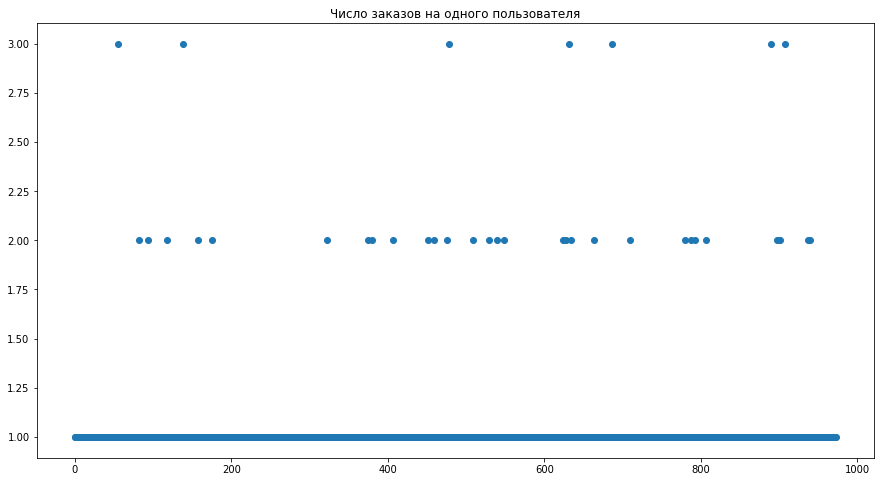

In [30]:
plt.figure(figsize=(15, 8))
x_values = pd.Series(range(0, len(orders_by_users)))
plt.scatter(x_values, orders_by_users['orders'])
plt.title('Число заказов на одного пользователя')
plt.show()

Имеем много пользователей, совершивших один единственный заказ. Второй заказ делают ощутимо реже, не говоря о третьем.

### <a id='7'>7. Граница для определения аномальных пользователей</a>

#### Посчитаем выборочные перцентили количества заказов на одного пользователя.

In [31]:
print('95-ый и 99-ый перцентили количества заказов на одного пользователя: {}'
      .format(np.percentile(orders_by_users['orders'], [95, 99])))

95-ый и 99-ый перцентили количества заказов на одного пользователя: [1. 2.]


Не более 1% пользователей оформляли более чем два заказа всего 5% пользователей заказывали более одного раза. Разумно выбрать 1 заказ на одного пользователя за нижнюю границу числа заказов и отсеять аномальных пользователей по ней.

### <a id='8'>8. Стоимость заказов</a>

#### Оценим стоимость заказов.

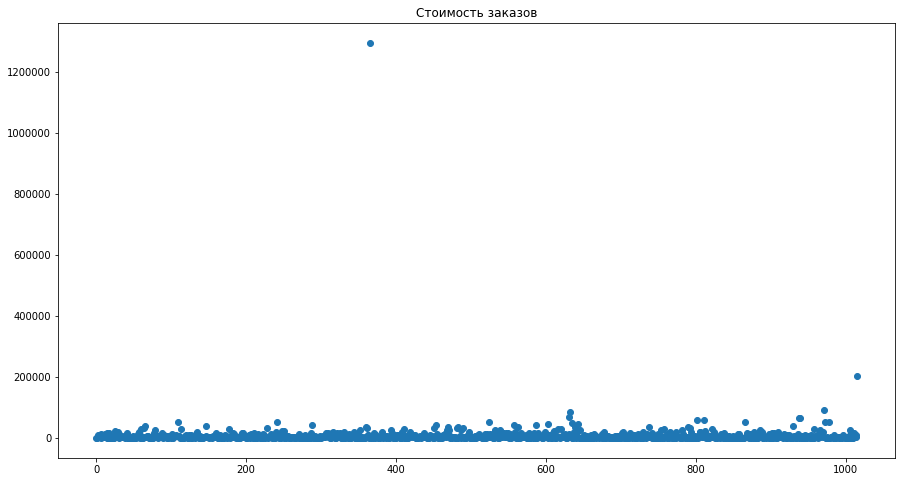

In [32]:
plt.figure(figsize=(15, 8))
x_values = pd.Series(range(0, len(orders['revenue'])))
plt.scatter(x_values, orders['revenue'])
plt.title('Стоимость заказов')
plt.show()

Дорогих заказов практически нет.

### <a id='9'>9. Граница для определения аномальных заказов</a>

#### Определим 95 и 99 перцентили стоимости заказов.

In [33]:
print('95-ый и 99-ый перцентили стоимости заказов: {}'
      .format(np.percentile(orders['revenue'], [95, 99])))

95-ый и 99-ый перцентили стоимости заказов: [26785. 53904.]


Будем считать аномальными заказы со стоимостью более 26 785 у.е.

### <a id='10'>10. Статистическая значимость различий в конверсии между группами по «сырым» данным</a>

**Нулевая гипотеза $H_0$**:
Различие в конверсии между группами по «сырым» данным не является статистически значимым.

**Альтернативная гипотеза $H_1$**:
Различие в конверсии между группами по «сырым» данным статистически значимо.

#### Посчитаем статистическую значимость различий в конверсии и среднем чеке между группами по «сырым» данным — без удаления аномальных пользователей.

In [34]:
visitors_a_daily = visitors[visitors['group'] == 'A'][['date', 'visitors']]
visitors_a_daily.columns = ['date', 'visitorsPerDateA']

visitors_a_cummulative = (
    visitors_a_daily
    .apply(
        lambda x: visitors_a_daily[
            visitors_a_daily['date'] <= x['date']
        ]
        .agg({'date': 'max', 'visitorsPerDateA': 'sum'}),
        axis=1
    )
)

visitors_a_cummulative.columns = ['date', 'visitorsCummulativeA']

visitors_b_daily = visitors[visitors['group'] == 'B'][['date', 'visitors']]
visitors_b_daily.columns = ['date', 'visitorsPerDateB']

visitors_b_cummulative = (
    visitors_b_daily
    .apply(
        lambda x: visitors_b_daily[
            visitors_b_daily['date'] <= x['date']
        ]
        .agg({'date': 'max', 'visitorsPerDateB': 'sum'}),
        axis=1
    )
)

visitors_b_cummulative.columns = ['date', 'visitorsCummulativeB']

orders_a_daily = (
    orders[orders['group'] == 'A'][['date', 'transactionId', 'visitorId', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transactionId': 'nunique', 'revenue': 'sum'})
)

orders_a_daily.columns = ['date', 'ordersPerDateA', 'revenuePerDateA']

orders_a_cummulative = (
    orders_a_daily
    .apply(
        lambda x: orders_a_daily[
            orders_a_daily['date'] <= x['date']
        ]
        .agg({'date': 'max', 'ordersPerDateA': 'sum', 'revenuePerDateA': 'sum'}),
        axis=1,
    )
    .sort_values(by='date')
)

orders_a_cummulative.columns = ['date', 'ordersCummulativeA', 'revenueCummulativeA']

orders_b_daily = (
    orders[orders['group'] == 'B'][['date', 'transactionId', 'visitorId', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transactionId': 'nunique', 'revenue': 'sum'})
)

orders_b_daily.columns = ['date', 'ordersPerDateB', 'revenuePerDateB']

orders_b_cummulative = (
    orders_b_daily
    .apply(
        lambda x: orders_b_daily[
            orders_b_daily['date'] <= x['date']
        ]
        .agg({'date': 'max', 'ordersPerDateB': 'sum', 'revenuePerDateB': 'sum'}),
        axis=1
    )
    .sort_values(by='date')
)

orders_b_cummulative.columns = ['date', 'ordersCummulativeB', 'revenueCummulativeB']

data = (
    orders_a_daily
    .merge(orders_b_daily, left_on='date', right_on='date', how='left')
    .merge(orders_a_cummulative, left_on='date', right_on='date', how='left')
    .merge(orders_b_cummulative, left_on='date', right_on='date', how='left')
    .merge(visitors_a_daily, left_on='date', right_on='date', how='left')
    .merge(visitors_b_daily, left_on='date', right_on='date', how='left')
    .merge(visitors_a_cummulative, left_on='date', right_on='date', how='left')
    .merge(visitors_b_cummulative, left_on='date', right_on='date', how='left')
)

#### Посчитаем статистическую значимость различия в конверсии между группами. Создадим переменные *orders_by_users_a* и *orders_by_users_b* со столбцами *visitorId* и *orders*. В них для пользователей, которые заказывали хотя бы 1 раз, укажем число совершённых заказов.

In [35]:
orders_by_users_a = (
    orders[orders['group'] == 'A']
    .groupby('visitorId', as_index=False)
    .agg({'transactionId': 'nunique'})
)

orders_by_users_a.columns = ['visitorId', 'orders']

orders_by_users_b = (
    orders[orders['group'] == 'B']
    .groupby('visitorId', as_index=False)
    .agg({'transactionId': 'nunique'})
)

orders_by_users_b.columns = ['visitorId', 'orders']

#### Объявим переменные *sample_a* и *sample_b*, в которых пользователям из разных групп будет соответствовать количество заказов. Тем, кто ничего не заказал, будут соответствовать нули. Это нужно, чтобы подготовить выборки к проверке критерием Манна-Уитни.

In [36]:
sample_a = (
    pd
    .concat(
        [
            orders_by_users_a['orders'],
            pd.Series(
                0,
                index=np.arange(
                    data['visitorsPerDateA'].sum() - len(orders_by_users_a['orders'])
                ),
                name='orders',
            ),
        ],
        axis=0
    )
)

sample_b = (
    pd.concat(
        [
            orders_by_users_b['orders'],
            pd.Series(
                0,
                index=np.arange(
                    data['visitorsPerDateB'].sum() - len(orders_by_users_b['orders'])
                ),
                name='orders',
            ),
        ],
        axis=0
    )
)

#### Выведем относительный прирост конверсии группы B.

In [37]:
print(
    'p-value = {0:.3f}'.format(
        st.mannwhitneyu(sample_a, sample_b, True, 'two-sided')[1]
    )
)

print(
    'Относительный прирост конверсии группы B = {0:.2%}'.format(
        sample_b.mean() / sample_a.mean() - 1
    )
)

p-value = 0.011
Относительный прирост конверсии группы B = 15.98%


Вывод: p-value < 0.05. Относительный выигрыш группы B над группой А в конверсии по «сырым» данным является статистически значимым.

### <a id='11'>11. Статистическая значимость различий в среднем чеке заказа между группами по «сырым» данным</a>

**Нулевая гипотеза $H_0$**:
Различие в среднем чеке заказа между группами по «сырым» данным не является статистически значимым.

**Альтернативная гипотеза $H_1$**:
Различие в среднем чеке заказа между группами по «сырым» данным статистически значимо.

#### Найдём относительное различие в среднем чеке между группами.

In [38]:
print(
    'p-value = {0:.3f}'.format(
        st.mannwhitneyu(
            orders[orders['group']=='A']['revenue'],
            orders[orders['group']=='B']['revenue'],
            True,
            'two-sided'
        )[1]
    )
)

print(
    'Относительное различие в среднем чеке между группами = {0:.2%}'.format(
        orders[orders['group']=='B']['revenue'].mean()
        / orders[orders['group']=='A']['revenue'].mean()
        - 1
    )
)

p-value = 0.829
Относительное различие в среднем чеке между группами = 28.66%


Вывод: p-value >> 0.05. Значит, причин отвергать нулевую гипотезу и считать, что в среднем чеке есть различия, нет. Впрочем, средний чек группы B выше среднего чека группы A (на 28%).

### <a id='12'>12. Статистическая значимость различий в конверсии между группами по «очищенным» данным</a>

**Нулевая гипотеза $H_0$**:
Различие в конверсии между группами по «очищенным» данным не является статистически значимым.

**Альтернативная гипотеза $H_1$**:
Различие в конверсии между группами по «очищенным» данным статистически значимо.

#### Узнаем, сколько всего аномальных пользователей.

In [39]:
users_with_many_orders = (
    pd
    .concat(
        [
            orders_by_users_a[orders_by_users_a['orders'] > 1]['visitorId'],
            orders_by_users_b[orders_by_users_b['orders'] > 1]['visitorId'],
        ],
        axis=0
    )
)

users_with_expensive_orders = orders[orders['revenue'] > 26785]['visitorId']

abnormal_users = (
    pd
    .concat(
        [
            users_with_many_orders, 
            users_with_expensive_orders
        ], 
        axis=0
    )
    .drop_duplicates()
    .sort_values()
)

print(f'Всего {abnormal_users.shape[0]} аномальных пользователей.') 

Всего 86 аномальных пользователей.


#### Посчитаем статистическую значимость различий в конверсии между группами теста по «очищенным» данным.

In [40]:
sample_a_filtered = (
    pd
    .concat(
        [
            orders_by_users_a[
                np.logical_not(orders_by_users_a['visitorId'].isin(abnormal_users))
            ]['orders'],
            pd.Series(
                0,
                index=np.arange(
                    data['visitorsPerDateA'].sum() - len(orders_by_users_a['orders'])
                ),
                name='orders',
            ),
        ],
        axis=0
    )
)

sample_b_filtered = (
    pd
    .concat(
        [
            orders_by_users_b[
                np.logical_not(orders_by_users_b['visitorId'].isin(abnormal_users))
            ]['orders'],
            pd.Series(
                0,
                index=np.arange(
                    data['visitorsPerDateB'].sum() - len(orders_by_users_b['orders'])
                ),
                name='orders',
            ),
        ],
        axis=0,
    )
)

In [41]:
print(
    'p-value = {0:.3f}'.format(
        st.mannwhitneyu(
            sample_a_filtered,
            sample_b_filtered,
            True,
            'two-sided'
        )[1]
    )
)

print(
    'Различие в конверсии между группами теста по «очищенным» данным = {0:.2%}'.format(
        sample_b_filtered.mean() / sample_a_filtered.mean() - 1
    )
) 

p-value = 0.016
Различие в конверсии между группами теста по «очищенным» данным = 17.39%


Результаты по конверсии на очищенных данных практически не изменились.

### <a id='13'>13. Статистическая значимость различий в среднем чеке заказа между группами по «очищенным» данным</a>

**Нулевая гипотеза $H_0$**:
Различие в среднем чеке заказа между группами по «очищенным» данным не является статистически значимым.

**Альтернативная гипотеза $H_1$**:
Различие в среднем чеке заказа между группами по «очищенным» данным статистически значимо.

In [42]:
print(
    'p-value = {0:.3f}'.format(
        st.mannwhitneyu(
            orders[
                np.logical_and(
                    orders['group'] == 'A',
                    np.logical_not(orders['visitorId'].isin(abnormal_users)),
                )
            ]['revenue'],
            orders[
                np.logical_and(
                    orders['group'] == 'B',
                    np.logical_not(orders['visitorId'].isin(abnormal_users)),
                )
            ]['revenue'],
            True, 
            'two-sided'
        )[1]
    )
)

print(
    'Различие в среднем чеке заказа между ' + 
    'группами по «очищенным» данным = {0:.2%}'.format(
        orders[
            np.logical_and(
                orders['group'] == 'B',
                np.logical_not(orders['visitorId'].isin(abnormal_users)),
            )
        ]['revenue'].mean()
        / orders[
            np.logical_and(
                orders['group'] == 'A',
                np.logical_not(orders['visitorId'].isin(abnormal_users)),
            )
        ]['revenue'].mean()
        - 1
    )
)

p-value = 0.727
Различие в среднем чеке заказа между группами по «очищенным» данным = -3.37%


Различие в среднем чеке заказа между группами по «очищенным» данным по прежнему не является статистически значимым, однако на них средний чек группы B стал даже ниже среднего чека группы A (-3.37%).

### <a id='14'>14. Решение по результатам теста</a>

Имеющиеся факты:
- Относительный выигрыш группы B над группой А в конверсии является статистически значимым как по «сырым», так и по «очищенным» данным, и составляет порядка 16-17%.
- Различие в среднем чеке заказа между группами не является статистически значимым ни по «сырым», ни по «очищенным» данным.
- График различия конверсии между группами сообщает, что наблюдается прирост конверсии группы B относительно группы A.

Исходя из обнаруженных фактов, тест следует остановить, зафиксировав победу группы B, то есть сбор базы клиентов для email-рассылок может повысить конверсию, не повлияв на средний чек.

### Вывод

Датафрейм **orders** состоит из 1 197 строк и 5 столбцов. Пропусков и дубликатов нет. Тип данных в столбце *date* — *object*, а не *datetime*.

Датафрейм **visitors** состоит из 62 строк и 3 столбцов. Пропусков и дубликатов нет. Тип данных в столбце *date* — *object*, а не *datetime*.

Типы данных в столбцах *date* датафреймов *orders* и *visitors* были приведены к типу *datetime64[ns]*.

Оказалось, что 58 пользователей попали одновременно в контрольную и тестовую группы. Такого быть не должно.

Доля пользователей, попавших в обе группы, составила 5.63%.
Доля заказов, совершённых этими пользователями: 15.12%.
Доля выручки от этих пользователей: 15.60%.

Как мы видим, таких пользователей не так много, однако 15% заказов и выручки принесли именно они. Тем не менее, для корректного анализа теста от этих данных пришлось избавиться.

Группа B обгоняет группу A по кумулятивной выручке почти с самого начала. Стоит отметить резкий рост графика кумулятивной выручки группы B в промежутке 17-21 августа. Это может сигнализировать о всплесках числа заказов или о появлении очень дорогих заказов в выборке.

Средний чек ведёт себя неравномерно на протяжении всего теста. Средний чек группы B резко растёт на том же самом временном промежутке, что и кумулятивная выручка этой группы. Заметно так называемое «возвращение к среднему», характерное для единоразовых мощных выбросов. Однозначно оценить эту метрику в разрезе групп по графику не удаётся.

В нескольких точках график различия между сегментами резко «скачет». Крупные заказы и выбросы, безусловно, присутствуют.

Кумулятивная конверсия группы A была лучше лишь в самом начале теста, после чего группа B вырвалась вперёд. К концу теста графики относительно стабилизировались.

Наблюдается прирост конверсии группы B относительно группы A.

Имеем много пользователей, совершивших один единственный заказ. Второй заказ делают ощутимо реже, не говоря о третьем.

Не более 1% пользователей оформляли более чем два заказа всего 5% пользователей заказывали более одного раза. Разумно выбрать 1 заказ на одного пользователя за нижнюю границу числа заказов и отсеять аномальных пользователей по ней.

Дорогих заказов практически нет. Будем считать аномальными заказы со стоимостью более 26 785 у.е.

Относительный выигрыш группы B над группой А в конверсии по «сырым» данным является статистически значимым.

Причин отвергать нулевую гипотезу и считать, что в среднем чеке есть различия, нет. Впрочем, средний чек группы B выше среднего чека группы A (на 28%).

Всего 86 аномальных пользователей.

Результаты по конверсии на «очищенных» данных практически не изменились.

Различия в среднем чеке заказа между группами по «очищенным» данным по прежнему не является статистически значимым, однако на них средний чек группы B стал даже ниже среднего чека группы A (-3.37%).

Имеющиеся факты:
- Относительный выигрыш группы B над группой А в конверсии является статистически значимым как по «сырым», так и по «очищенным» данным, и составляет порядка 16-17%.
- Различие в среднем чеке заказа между группами не является статистически значимым ни по «сырым», ни по «очищенным» данным.
- График различия конверсии между группами сообщает, что наблюдается прирост конверсии группы B относительно группы A.

Исходя из обнаруженных фактов, тест следует остановить, зафиксировав победу группы B, то есть сбор базы клиентов для email-рассылок может повысить конверсию, не повлияв на средний чек.